In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, logistic
from scipy.optimize import minimize

In [2]:
data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

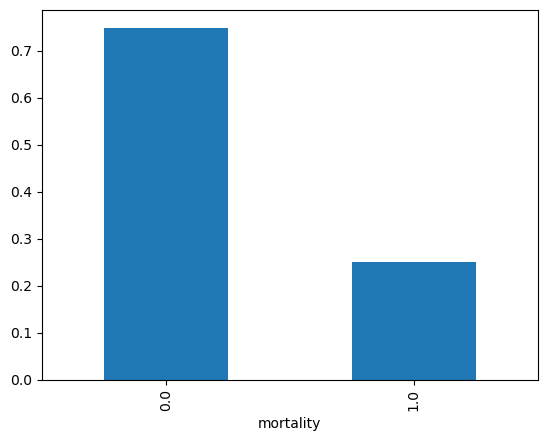

In [3]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

In [4]:
x = df.drop('mortality',axis=1)
x /= x.mean()
x = x.fillna(0).values
y = df.mortality.values

In [16]:
#def log_logistic_fn(x):
#    return np.log(1+np.exp(-x)) 


class logisticModel():
    
    def __init__(self):
        self.param = np.zeros(x.shape[1]+1)

    def __logistic_loss(self,param, x, y):
        p = param[:-1]
        b = param[-1]
        score = np.dot(x,p) + b
        diff = -y*logistic.logcdf(score, loc=0, scale=1) - (1-y)*logistic.logcdf(-score, loc=0, scale=1)
        return np.mean(diff)

    def fit(self, x, y):
        loss_values = []

        def callback(param):
            current_loss = self.__logistic_loss(param, x, y)
            loss_values.append(current_loss)
            print("Current loss:", current_loss)
        
        result = minimize(self.__logistic_loss, self.param, args=(x, y), method='BFGS', tol=1e-3, options={'maxiter':1000}, callback=callback)
        self.param = result.x
        return result, loss_values
    
    def predict(self, x):
        p = self.param[:-1]
        b = self.param[-1]
        score = np.dot(x,p) + b
        return logistic.cdf(score, loc=0, scale=1)


class probitModel():
    
    def __init__(self):
        self.param = np.zeros(x.shape[1]+1)

    def __probit_loss(self, param, x, y):
        p = param[:-1]
        b = param[-1]
        score = np.dot(x,p) + b
        diff = -y*norm.logcdf(score, loc=0, scale=1) - (1-y)*norm.logcdf(-score, loc=0, scale=1)
        return np.mean(diff)

    def fit(self, x, y):
        loss_values = []

        def callback(param):
            current_loss = self.__probit_loss(param, x, y)
            loss_values.append(current_loss)
            print("Current loss:", current_loss)
        
        result = minimize(self.__probit_loss, self.param, args=(x, y), method='BFGS', tol=1e-3, options={'maxiter':1000}, callback=callback)
        self.param = result.x
        return result, loss_values
    
    def predict(self, x):
        p = self.param[:-1]
        b = self.param[-1]
        score = np.dot(x,p) + b
        return norm.cdf(score, loc=0, scale=1)

In [17]:
probit = probitModel()
result, loss_values = probit.fit(x,y)
print("Optimized parameters (b):", result.x)

Current loss: 0.6564944171545902
Current loss: 0.6115973740716285
Current loss: 0.5803994582281048
Current loss: 0.5737104220981541
Current loss: 0.564956071606672
Current loss: 0.5605604429071054
Current loss: 0.557119020196032
Current loss: 0.5537670455846764
Current loss: 0.5518817409951497
Current loss: 0.5514844929333712
Current loss: 0.5498399334677153
Current loss: 0.5492771382692572
Current loss: 0.5467936661665794
Current loss: 0.5434987243206898
Current loss: 0.5427308568032827
Current loss: 0.5413978291668416
Current loss: 0.5397432507865162
Current loss: 0.537951913907641
Current loss: 0.5364639582739287
Current loss: 0.5347724413842977
Current loss: 0.533645348715959
Current loss: 0.5332373023694047
Current loss: 0.532707940297981
Current loss: 0.5323111172578993
Current loss: 0.5320218847207557
Current loss: 0.531641843568042
Current loss: 0.5313493405453064
Current loss: 0.5312246857478311
Current loss: 0.5310083765563034
Current loss: 0.5306827870373808
Current loss: 0.

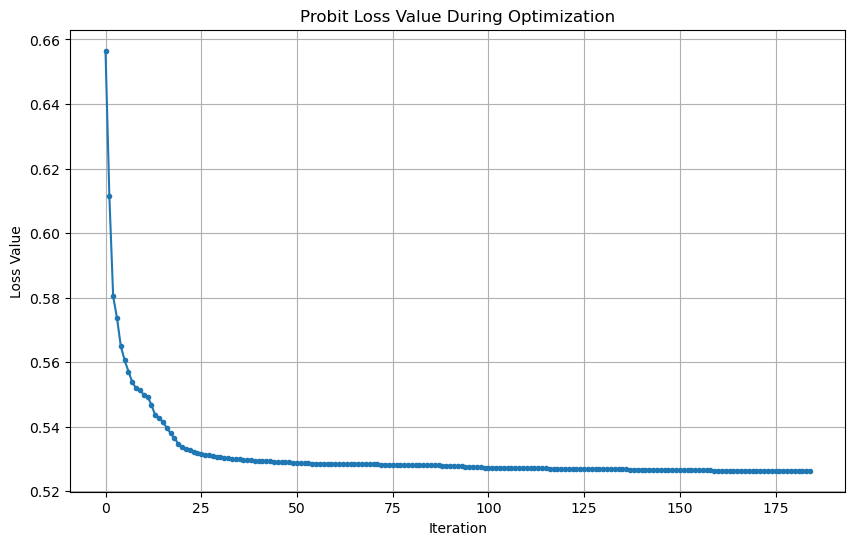

In [18]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

(array([ 353., 1744., 1946.,  976.,  413.,  169.,   35.,    9.,    0.,
           2.]),
 array([2.91684583e-273, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <BarContainer object of 10 artists>)

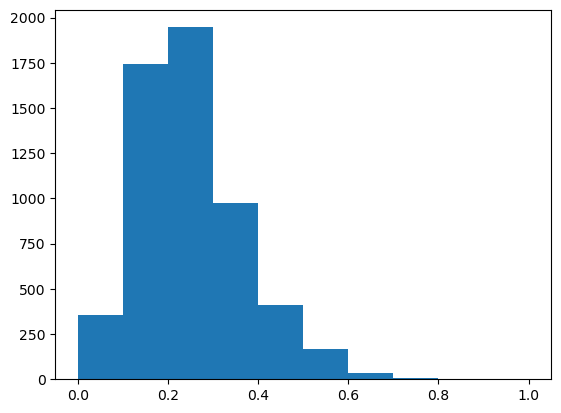

In [19]:
plt.hist(probit.predict(x))

In [20]:
logit = logisticModel()
result, loss_values = logit.fit(x,y)
print("Optimized parameters (b):", result.x)

Current loss: 0.5970322426301833
Current loss: 0.5804472803993189
Current loss: 0.5714821461453015
Current loss: 0.5681517661014819
Current loss: 0.5634960078369764
Current loss: 0.5627893520310469
Current loss: 0.561591522402571
Current loss: 0.559801097445491
Current loss: 0.5567754461637806
Current loss: 0.5551070759068732
Current loss: 0.5546888193871099
Current loss: 0.5510554268841595
Current loss: 0.5504028197321801
Current loss: 0.5495057761539602
Current loss: 0.5478944538167388
Current loss: 0.5454165282545107
Current loss: 0.5450724679354391
Current loss: 0.5450007381185927
Current loss: 0.5443321480837098
Current loss: 0.5431541862395087
Current loss: 0.5413150615394953
Current loss: 0.5394136953037871
Current loss: 0.5381761210807332
Current loss: 0.5362773055074508
Current loss: 0.5350820674849069
Current loss: 0.534730057408696
Current loss: 0.5341460904931224
Current loss: 0.5333005240319817
Current loss: 0.5327263040795129
Current loss: 0.5324310262153985
Current loss:

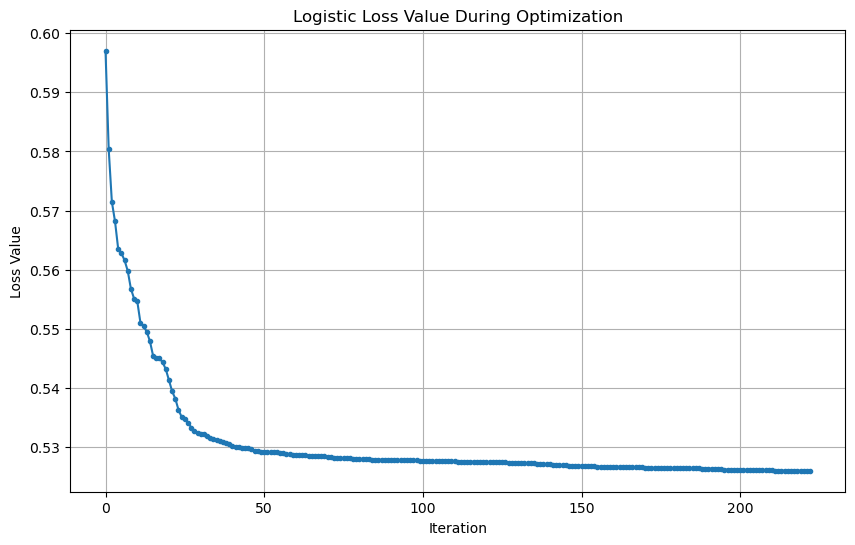

In [21]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

In [31]:
logit.predict(x)

array([0.19557748, 0.20075797, 0.24707954, ..., 0.10899482, 0.22865976,
       0.24146333])

(array([3.360e+02, 1.834e+03, 1.916e+03, 9.160e+02, 4.080e+02, 1.780e+02,
        4.700e+01, 9.000e+00, 2.000e+00, 1.000e+00]),
 array([2.42405875e-32, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

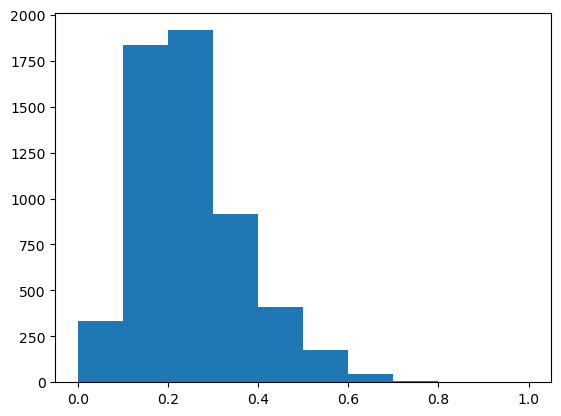

In [22]:
plt.hist(logit.predict(x))

In [25]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(fit_intercept=True, solver='newton-cg')
model.fit(x, y)
b_sklearn = model.coef_[0]  # Weights (b)
bias_sklearn = model.intercept_[0]  # Bias term


In [46]:
from sklearn.metrics import log_loss

log_loss(y, model.predict_proba(x), eps=1e-15)

0.5271450639664295